In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.clear()

In [3]:
quadh_index = eightb.get_quadH_pairings()

In [4]:
to_cc = lambda array : '{'+','.join(map(str,array))+'}'
jets = list(range(8))
all_pairs = [ (j0,j1) for j0 in jets for j1 in jets[j0+1:] ]
# print(',\n'.join(map(to_cc,all_pairs)))
# print(',\n'.join(map(to_cc,quadh_index)))

In [8]:
signal_trees = ObjIter([Tree(fn) for fn in fc.eightb.preselection.signal_list])
# bkg_trees = TreeIter([Tree(fc.eightb.preselection.QCD_B_List)])

# all_trees = signal_trees + bkg_trees

all_trees = signal_trees[[6]]

In [10]:
all_trees.apply(eightb.select_topbtag)

[None]

In [11]:
all_trees.extend(kwargs=lambda t : dict(
    n_matched_jet=ak.sum(t.jet_signalId > -1,axis=-1)
))

[None]

In [12]:
signal = signal_trees[6]

In [13]:
signal = EventFilter('eightb',n_matched_jet=8).filter(signal)

In [15]:
signal.extend(**eightb.reco_all(signal))
build_collection(signal,'gen_H\dY\d','gen_higgs')

In [23]:
training = get_collection(signal[signal.nfound_presel==8],'gen_higgs',False)
training = training[ak.argsort(-training.reco_pt,axis=-1)]

In [24]:
def mass_std(dijets):
    ms = dijets.m[:,quadh_index]
    return np.std(ms.to_numpy().reshape(-1,4),axis=-1).reshape(-1,105)
def mass_dif_v2(dijets):
    ms = dijets.m[:,quadh_index]
    ms_numpy = ms.to_numpy().reshape(-1,4)
    ms_numpy.sort(axis=-1)
    score = (ms_numpy[:,0]-ms_numpy[:,3])**2 + (ms_numpy[:,1]-ms_numpy[:,2])**2
    return score.reshape(-1,105)
def mass_dif_v3(dijets):
    ms = dijets.m[:,quadh_index]
    ms_numpy = ms.to_numpy().reshape(-1,4)
    ms_numpy.sort(axis=-1)
    score = (ms_numpy[:,0]-ms_numpy[:,1])**2 + (ms_numpy[:,0]-ms_numpy[:,2])**2 + (ms_numpy[:,0]-ms_numpy[:,3])**2 + (ms_numpy[:,1]-ms_numpy[:,2])**2 + (ms_numpy[:,1]-ms_numpy[:,3])**2 + (ms_numpy[:,2]-ms_numpy[:,3])**2
    return score.reshape(-1,105)
def mass_loc(dijets):
    ms = dijets.m[:,quadh_index]
    ms_numpy = ms.to_numpy().reshape(-1,4)
    mu = np.array([128, 122, 120, 116])
    return np.sum(np.abs(ms_numpy-mu),axis=-1).reshape(-1,105)

In [189]:
def pair_higgs(tree,operator=mass_std,nsave=4):
    dijets = get_collection(tree,'dijet',False)
    score = ak.from_regular(operator(dijets),axis=-1)
    best_score = ak.argsort(score,axis=-1)
    score = score[best_score]
    form = {0:''}
    for save in range(nsave):
        best_index = ak.from_regular(best_score[:,save])
        dijet_index = ak.from_regular(np.array(quadh_index)[best_index],axis=-1)
        higgs = dijets[dijet_index]
        higgs = higgs[ak.argsort(-higgs.pt,axis=-1)]
        tree.extend(
            rename_collection(higgs,f'higgs{form.get(save,save)}'),
            **{
                f'score_4h{form.get(save,save)}':score[:,save],
                f'nfound_h{form.get(save,save)}':ak.sum(higgs.signalId>-1,axis=-1),
                f'h{form.get(save,save)}_msum':ak.sum(higgs.m,axis=-1),
                f'h{form.get(save,save)}_ptsum':ak.sum(higgs.pt,axis=-1)
                })
    return tree

In [190]:
mass_dif_paired = pair_higgs(signal.copy(),mass_dif)
mass_difv2_paired = pair_higgs(signal.copy(),mass_dif_v2)
mass_difv3_paired = pair_higgs(signal.copy(),mass_dif_v3)

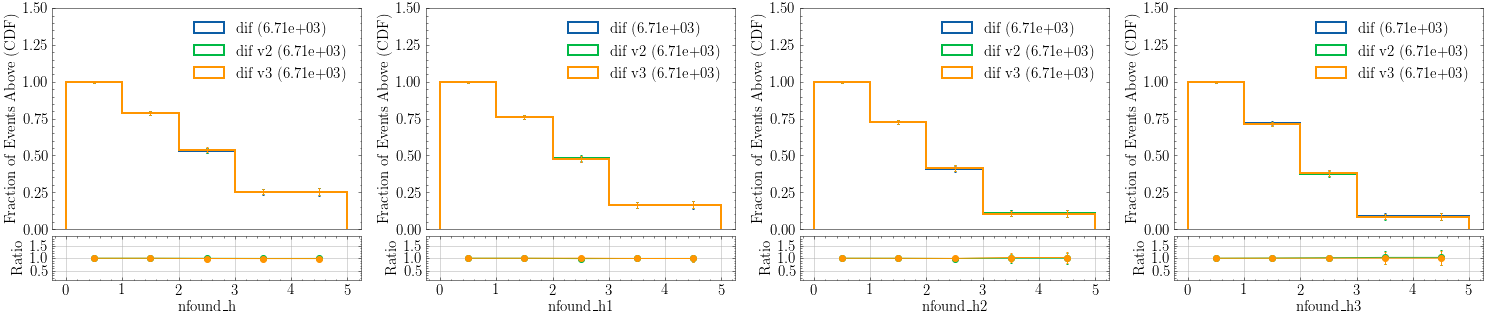

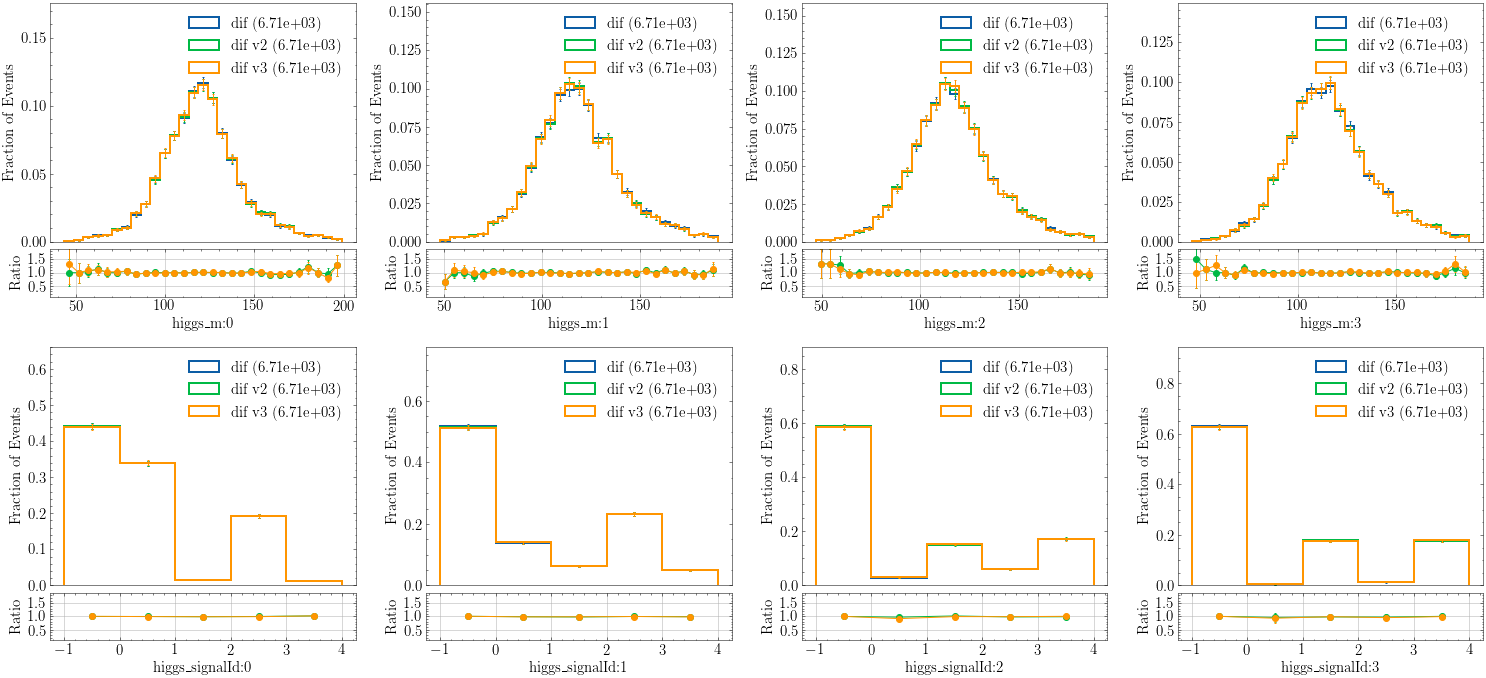

In [191]:
# treeiter = [mass_loc_paired,mass_dif_paired,mass_difv2_paired,mass_std_paired,mass_dif_paired]
treeiter = [mass_dif_paired,mass_difv2_paired,mass_difv3_paired]
kwargs = dict(s_colors=None,
    # labels=['Loc','dif','dif v2','Std','dif'],
    labels=['dif','dif v2','dif v3'],
    ratio=True,
    # r_ylim=(0.90,1.1),
    scale=False,
    density=True,
    )


study.quick(
    treeiter,
    varlist=['nfound_h','nfound_h1','nfound_h2','nfound_h3'],
    cumulative=-1,
    dim=(-1,4),
    **kwargs
)

study.quick(
    treeiter,
    varlist=['higgs_m:0','higgs_m:1','higgs_m:2','higgs_m:3','higgs_signalId:0','higgs_signalId:1','higgs_signalId:2','higgs_signalId:3'],
    dim=(-1,4),
    **kwargs
)

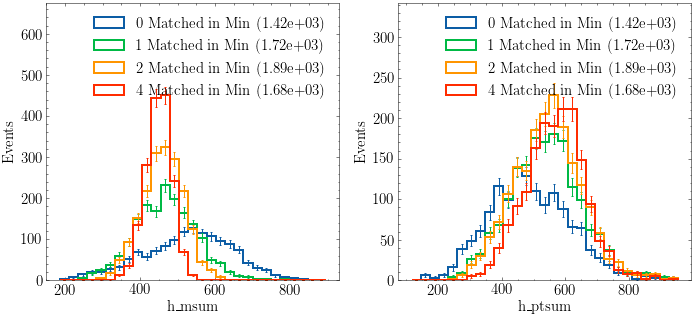

In [192]:
tree = mass_dif_paired
study.quick(
    [tree]*4,
    masks=[tree.nfound_h == 0, tree.nfound_h == 1,tree.nfound_h == 2, tree.nfound_h == 4],
    varlist=[ 'h_msum','h_ptsum' ],
    s_colors=None,
    labels=[f"{i} Matched in Min" for i in (0,1,2,4)],
    scale=False,
    # dim=(-1,4)
)

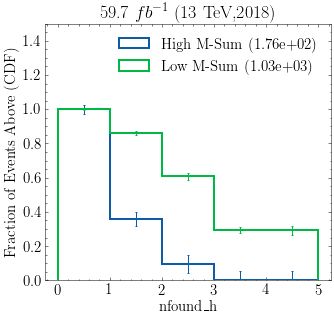

In [179]:

study.quick(
    [tree]*2,
    masks=[tree.h_msum > 550, tree.h_msum < 550],
    varlist=['nfound_h'],
    s_colors=None,
    labels=["High M-Sum","Low M-Sum"],
    cumulative=-1
)

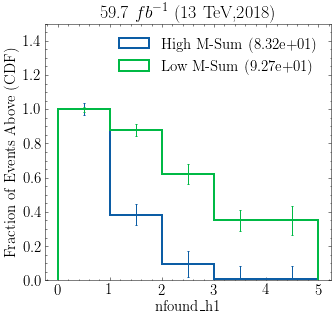

In [183]:

study.quick(
    [tree]*2,
    masks=[(tree.h_msum>550) & (tree.h1_msum > 550), (tree.h_msum>550) & (tree.h1_msum < 550)],
    varlist=['nfound_h1'],
    s_colors=None,
    labels=["High M-Sum","Low M-Sum"],
    cumulative=-1
)

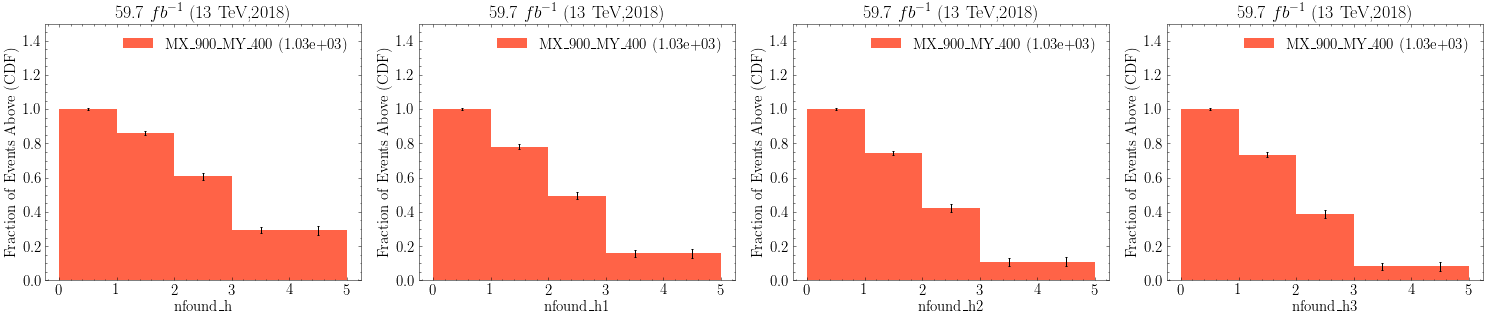

In [174]:
mask = tree.h_msum < 550

study.quick(
    [tree],
    masks=[mask],
    varlist=['nfound_h','nfound_h1','nfound_h2','nfound_h3'],
    cumulative=-1,
    dim=(-1,4)
)

(<Figure size 384x360 with 1 Axes>,
 <AxesSubplot:ylabel='Fraction of Events Above (CDF)'>)

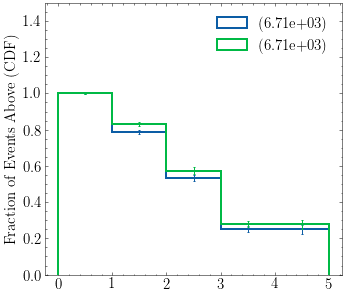

In [187]:
nfound_merge = ak.where(tree.h_msum < 550,tree.nfound_h,tree.nfound_h1)
hist_multi([tree.nfound_h, nfound_merge],cumulative=-1)

In [188]:
ak.sum(nfound_merge==4)/ak.count(nfound_merge)

0.27832438878950505